## Семинар 1 "Полносвязные нейронные сети"

ФИО: Склянный Алексей

группа: МЛ-21

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400/>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        self.W = np.random.rand(input_size, output_size) * 0.1
        # self.b = np.zeros(output_size)
        self.output_size = output_size
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.b = np.zeros((X.shape[0], self.output_size))
        
        self.X = X
        self.Y = X @ self.W + self.b
        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        
        self.dLdW = self.X.T @ dLdy
        self.dLdb = dLdy
        self.dLdx = dLdy @ self.W.T
        
        return self.dLdx
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        self.W -= learning_rate * self.dLdW
        self.b -= learning_rate * self.dLdb

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [3]:
eps = 10**(-6)
eps_debug = 10**(-10)
# n_objects_x = np.array([[1, 2, -1, 0], [3, 1, 2, -1]])

input_v = 2
outout_v = 3
num_objects = 10

sample_x = np.random.rand(num_objects, input_v) * 100

def check_gradient(func, X, gradient=0):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    grad_X = np.zeros(X.shape)
    for i in np.arange(grad_X.shape[0]):
        for j in np.arange(grad_X.shape[1]):
            X[i, j] += eps
            f_plus = func(X)
            X[i, j] -= eps
            
            X[i, j] -= eps
            f_minus = func(X)
            X[i, j] += eps
            
            grad_X[i, j] = (f_plus - f_minus) / (2 * eps)
            
    #debug        
    print(f"numerical gradient:\n{grad_X},\ndifferentiated gradient:\n{gradient}")
#     print(f"{grad_X[grad_X - gradient >= eps_debug]=}")
    
    return np.abs(gradient - grad_X).max()

In [4]:
linear = Linear(input_v, outout_v)

def f(W, linear=linear, sample_x=sample_x):
    return linear.forward(sample_x).sum()

res = f(None)
linear.backward(np.ones((num_objects, outout_v)))

print("Max absolute diviation:", end="\n\n")
print(f"dLdW = {check_gradient(f, linear.W, linear.dLdW)}", end="\n\n")
print(f"dLdx = {check_gradient(f, linear.X, linear.dLdx)}", end="\n\n")

Max absolute diviation:

numerical gradient:
[[473.13065843 473.13065846 473.13065843]
 [369.94448136 369.94448136 369.94448136]],
differentiated gradient:
[[473.13065844 473.13065844 473.13065844]
 [369.94448137 369.94448137 369.94448137]]
dLdW = 2.7456451334728627e-08

numerical gradient:
[[0.19813699 0.09959463]
 [0.198137   0.09959463]
 [0.19813699 0.09959463]
 [0.198137   0.09959463]
 [0.19813699 0.09959463]
 [0.19813699 0.09959463]
 [0.198137   0.09959463]
 [0.19813699 0.09959463]
 [0.19813699 0.09959464]
 [0.198137   0.09959463]],
differentiated gradient:
[[0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]]
dLdx = 1.0748347989419926e-08



Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

### Часть 3: Сигмоида

In [5]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.Y = 1 / (1 + np.exp(-X))
        
        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        self.dLdx = dLdy * self.Y * (1 - self.Y)
        
        return self.dLdx
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [6]:
sigm = Sigmoid()

# sample_x = np.random.rand(num_objects, input_v) * 100

sigm.forward(sample_x).sum()

def f(X, sigm=sigm):
    return sigm.forward(X).sum()

sample_x_copy = np.copy(sample_x)
print(f"max absolute diviate = {check_gradient(f, sample_x_copy, sigm.backward(np.ones(sample_x.shape)))}")

numerical gradient:
[[0.00000000e+00 0.00000000e+00]
 [1.23456800e-06 0.00000000e+00]
 [0.00000000e+00 6.39488462e-08]
 [0.00000000e+00 0.00000000e+00]
 [1.11910481e-06 0.00000000e+00]
 [0.00000000e+00 1.03479714e-03]
 [6.68691058e-03 1.27968747e-05]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]],
differentiated gradient:
[[0.00000000e+00 0.00000000e+00]
 [1.23462182e-06 6.30606678e-14]
 [0.00000000e+00 6.30247250e-08]
 [0.00000000e+00 2.16791030e-11]
 [1.11868762e-06 6.97442104e-13]
 [0.00000000e+00 1.03479585e-03]
 [6.68691175e-03 1.27976518e-05]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [1.02508446e-10 0.00000000e+00]]
max absolute diviate = 1.2828820377969868e-09


### Часть 4.1, NLLLoss

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [7]:
# проверка правильности реализации softmax

tmp = np.array([
    [1, 2],
    [3, 4],
    [5, 6]]
)

up = np.exp(tmp)
down = np.sum(np.exp(tmp), axis=1)


print(np.exp(tmp) / np.sum(np.exp(tmp), axis=1).reshape(-1, 1), end="\n\n")
# inf = np.exp(tmp) / np.sum(np.exp(tmp), axis=1)

print(f"{(np.exp(6) / (np.exp(5) + np.exp(6))) = }", end="\n\n")

print(f"{np.exp(tmp) = }", end="\n\n")
print(f"{np.sum(np.exp(tmp), axis=1).reshape(-1, 1) = }", end="\n\n")

print(f"{up=}", end="\n\n")
print(f"{down=}", end="\n\n")

[[0.26894142 0.73105858]
 [0.26894142 0.73105858]
 [0.26894142 0.73105858]]

(np.exp(6) / (np.exp(5) + np.exp(6))) = 0.7310585786300049

np.exp(tmp) = array([[  2.71828183,   7.3890561 ],
       [ 20.08553692,  54.59815003],
       [148.4131591 , 403.42879349]])

np.sum(np.exp(tmp), axis=1).reshape(-1, 1) = array([[ 10.10733793],
       [ 74.68368696],
       [551.8419526 ]])

up=array([[  2.71828183,   7.3890561 ],
       [ 20.08553692,  54.59815003],
       [148.4131591 , 403.42879349]])

down=array([ 10.10733793,  74.68368696, 551.8419526 ])



In [8]:
class NLLLossLogSumExp:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y
        
        self.exp_diff = np.exp(X - np.max(X))
        
        self.p = self.exp_diff / np.sum(self.exp_diff, axis=1).reshape(-1, 1)
        
        # log_sum_exp
        self.loss = -(X - np.log(np.sum(self.exp_diff, axis=1)).reshape(-1, 1) - np.max(X))
        
        return self.loss[np.array(self.indicator(X, self.y), dtype=bool)]
    
    def indicator(self, X, y):
        res = np.zeros(X.shape, dtype=int)
        for i in np.arange(X.shape[0]):
            res[i][y[i]] = 1

        return res

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        self.dLdx = self.p - self.indicator(self.X, self.y)
        
        return self.dLdx

In [9]:
class NLLLoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y
        
        self.p = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
        
        # log_sum_exp
        self.loss = -(X - np.log(np.sum(np.exp(X - np.max(X)), axis=1)).reshape(-1, 1) - np.max(X))
        
        return self.loss[np.array(self.indicator(X, self.y), dtype=bool)]
    
    def indicator(self, X, y):
        res = np.zeros(X.shape, dtype=int)
        for i in np.arange(X.shape[0]):
            res[i][y[i]] = 1

        return res

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        self.dLdx = self.p - self.indicator(self.X, self.y)
        
        return self.dLdx

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [10]:
nll_l = NLLLoss()

def f(W, nll_l=nll_l, sample_x=sample_x):
    return linear.forward(sample_x).sum()

res = f(None)
linear.backward(np.ones((num_objects, outout_v)))

print("Max absolute diviation:", end="\n\n")
print(f"dLdx = {check_gradient(f, linear.X, linear.dLdx)}", end="\n\n")

Max absolute diviation:

numerical gradient:
[[0.19813699 0.09959463]
 [0.198137   0.09959463]
 [0.19813699 0.09959463]
 [0.198137   0.09959463]
 [0.19813699 0.09959463]
 [0.19813699 0.09959463]
 [0.198137   0.09959463]
 [0.19813699 0.09959463]
 [0.19813699 0.09959464]
 [0.198137   0.09959463]],
differentiated gradient:
[[0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]
 [0.198137   0.09959463]]
dLdx = 1.0748347989419926e-08



### Часть 4.2, MSELoss

In [11]:
class MSELoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        self.n = X.shape[0]
        self.diff = X - y[:, None]
        return (self.diff**2).mean()
    
    def backward(self):
        dLdx = 1 / self.n * (2 * self.diff)
        
        return dLdx

### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [12]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = list(modules)
    
    def forward(self, X):
        for module in self.modules:
            X = module.forward(X)
        
        return X
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for module in self.modules[::-1]:
            dLdy = module.backward(dLdy)
    
    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)

### Часть 6, обучение на простых данных

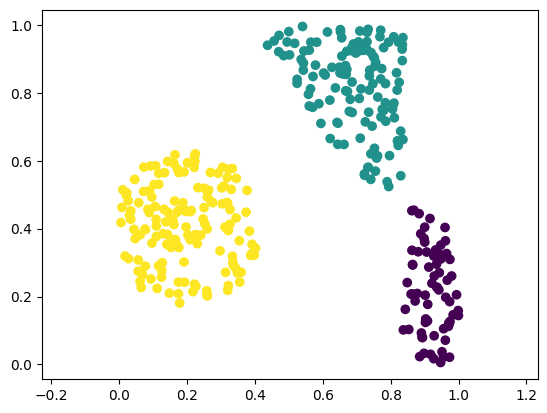

In [13]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?

Отличная визуализация: http://playground.tensorflow.org/

## Домашнее задание:

* Подоберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

### MSELoss

In [14]:
mse_nn = NeuralNetwork([Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 1)])
mse_learning_rate = 0.05
mse_count = 10000

def mse_loss(X=X, y=y, learning_rate=mse_learning_rate, count=mse_count, nn=mse_nn):
    loss = MSELoss()

    losses = []

    for epoch in np.arange(count):
        prediction = nn.forward(X)

        L = loss.forward(prediction, y)
        losses.append(L)

        dLdy = loss.backward()

        nn.backward(dLdy)
        nn.step(learning_rate)

    return losses, prediction

mse_losses, mse_prediction = mse_loss()

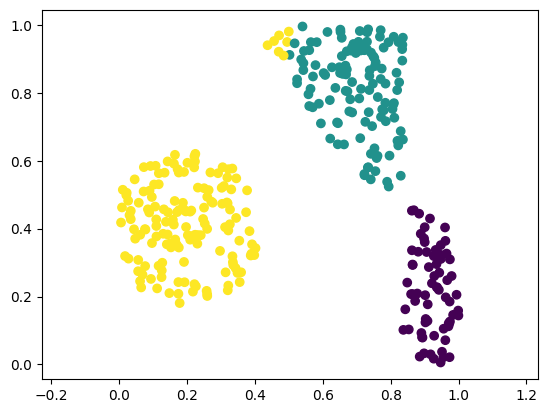

In [15]:
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=np.round(mse_prediction.flatten()))
plt.axis('equal')
plt.show()

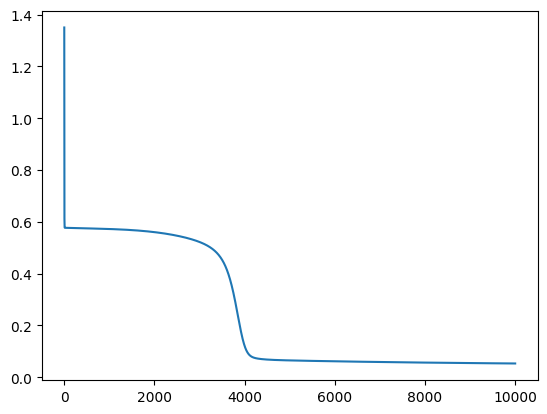

In [16]:
plt.plot(mse_losses)

### NLLLoss

In [75]:
class NLLLossLay:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] =1
        return -(np.log(self.p)*self.y).sum(1).mean(0)
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


In [131]:
nll_nn = NeuralNetwork([Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)])
nll_learning_rate = 0.005
nll_count = 1000
loss = NLLLossLogSumExp()

def nll_loss(X=X, y=y, learning_rate=nll_learning_rate, count=nll_count, nn=nll_nn, loss=loss):

    losses = []
    dLdy_max = []

    for epoch in np.arange(count):
        prediction = nn.forward(X)

        L = loss.forward(prediction, y).mean()
        losses.append(L)

        dLdy = loss.backward()
        dLdy_max.append(np.max(dLdy))

        nn.backward(dLdy)
        nn.step(learning_rate)  
    
    return losses, prediction, dLdy_max

nll_losses, nll_prediction, dLdy_max = nll_loss()

In [132]:
max(dLdy_max)

0.6457473570906783

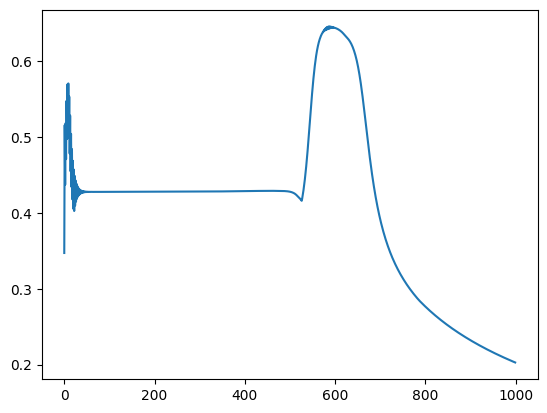

In [133]:
plt.plot(dLdy_max)

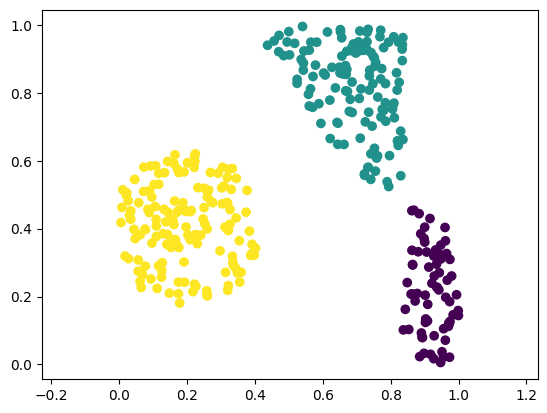

In [134]:
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=np.round(np.argmax(nll_prediction, axis=1)))
plt.axis('equal')
plt.show()

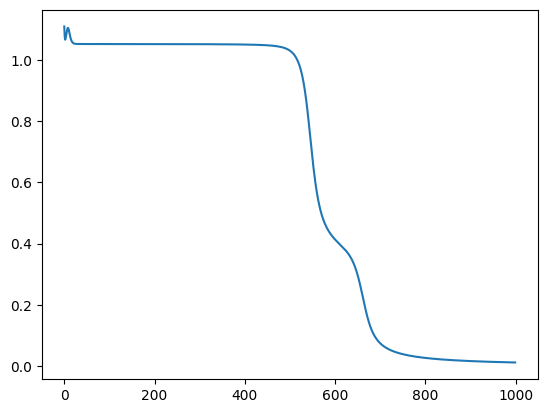

In [135]:
plt.plot(nll_losses)

## Проверка функции потерь от learning rate 

[0.4684694248858232, 0.06971983770238852, 0.0279505792568532, 0.014756181209003513, 0.009004590520169145, 0.0060178875512788286, 0.004281690635837988, 0.003189099645095395, 0.002459777199182247]


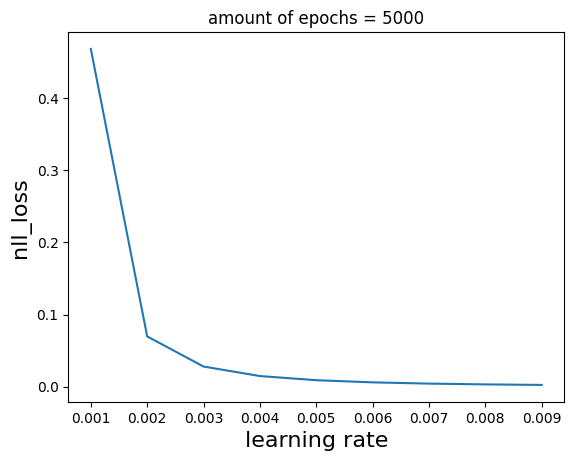

In [19]:
nll_lst = []
nll_nn = NeuralNetwork([Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)])
epoch_nums = 5000
start, end, step = 0.001, 0.01, 0.001#0, 1.01, 0.1

for lr in np.arange(start, end, step):
    nll_losses, nll_prediction = nll_loss(X, y, lr, epoch_nums, nll_nn)
    
    nll_lst.append(sum(nll_losses[-1:-50:-1]))

print(nll_lst)

lr = np.arange(start, end, step)

plt.plot(lr, nll_lst)
plt.xlabel('learning rate', fontsize=16)
plt.ylabel('nll_loss', fontsize=16)
plt.title(f'amount of epochs = {epoch_nums}')
plt.show()

[2.530816575773397, 2.2734207299317015, 1.3643269284585517, 0.604180650960542, 0.3394986653905313, 0.2216318884161619, 0.12489991151125954, 0.09372207836574126, 0.0807350564062631, 0.07090947212830254, 0.061718078195076076]


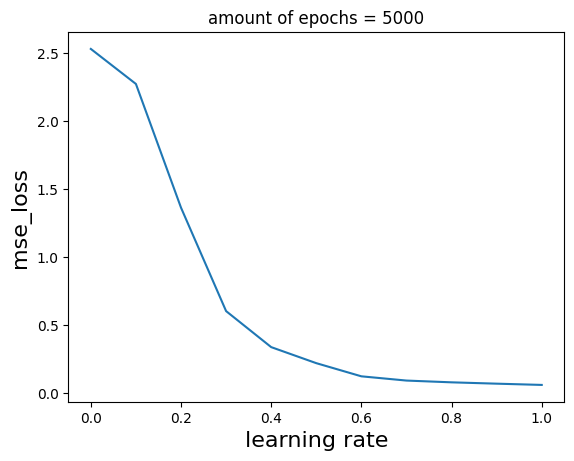

In [20]:
mse_lst = []
# epoch_nums = 1000
start, end, step = 0, 1.01, 0.1

for lr in np.arange(start, end, step):
    mse_losses, mse_prediction = mse_loss(X, y, lr, epoch_nums, mse_nn)
    
    mse_lst.append(sum(mse_losses[-1:-50:-1]))

print(mse_lst)


lr = np.arange(start, end, step)

plt.plot(lr, mse_lst)
plt.xlabel('learning rate', fontsize=16)
plt.ylabel('mse_loss', fontsize=16)
plt.title(f'amount of epochs = {epoch_nums}')
plt.show()

Сложность посторения графика заключается в том, что при различных значениях эпох и learning rate модуль будет неправлиьно обучаться (например, все объекты присваивать одному классу, и значение лоса при этом может быть мало)

# Вывод
Необходимо стремиться подбирать оптимальный learning rate: при выборе большого значения градиент может "перескакивать" значение локального экстремума, при выборе слишком малого значения - время выполнения алгоритма будет слишком большое.